# Figure 4: S100A4 ensemble epistasis analysis


Here we are loading in Rosetta output and assuming there is a correlation between Rosetta units and kcal/mol units. (see Kellogg et al, 2011).

## Imports

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Some pretty plot defaults
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

## Load data from ROSETTA. 

Each line of the text file (output-cycles.txt) has 20 entries in the following order, delimited by commas, with no line breaks.  
(Spacing and line breaks here for human sanity).
```
mut_one,mut_two,

apo_mean_ddG_m1,apo_mean_ddG_m2,apo_mean_ddG_m1m2,
ca_mean_ddG_m1,ca_mean_ddG_m2,ca_mean_ddG_m1m2,
capep_mean_ddG_m1,capep_mean_ddG_m2,capep_mean_ddG_m1m2,

apo_std_ddG_m1,apo_std_ddG_m2,apo_std_ddG_m1m2,
ca_std_ddG_m1,ca_std_ddG_m2,ca_std_ddG_m1m2,
capep_std_ddG_m1,capep_std_ddG_m2,capep_std_ddG_m1m2
```

+ `mut_one` and `mut_two` are human-readable names of the mutations (like V72K, etc.)
+ `apo`, `ca`, and `capep` refer to the state on which the calculation was done. 
+ `mean` and `std` indicate whether this is the mean ddG calcualted or the standard deviation on the set of ddG calcultions. 
+ `m1`, `m2`, and `m1m2` refer to whether this is the effect of mutation 1, mutation 2, or mutation 1 and 2 together.  For most mutations, the `m1m2` value is `np.na` because the calculation was not done. 
+ energies are in ROSETTA energy units

### `output-cycles.txt` is too large to include in the github repo.  See the `rosetta` directory for how to generate. 

In [2]:
file_with_cycles = "output-cycles.txt"

def count_lines_in_file(filename):
    """
    Very quickly count the number of lines in a file.
    
    Following this discusssion:
    
    # https://stackoverflow.com/questions/9629179/python-counting-lines-in-a-huge-10gb-file-as-fast-as-possible
    """
    
    def blocks(files, size=65536):
        while True:
            b = files.read(size)
            if not b: break
            yield b

    
    with open(filename, "r",encoding="utf-8",errors='ignore') as f:
        count = sum(bl.count("\n") for bl in blocks(f))
        
    return count


num_lines = count_lines_in_file(file_with_cycles)

apo_ddG_mean = np.zeros((num_lines,3),dtype=np.float)
ca_ddG_mean = np.zeros((num_lines,3),dtype=np.float)
capep_ddG_mean = np.zeros((num_lines,3),dtype=np.float)

apo_ddG_std = np.zeros((num_lines,3),dtype=np.float)
ca_ddG_std = np.zeros((num_lines,3),dtype=np.float)
capep_ddG_std = np.zeros((num_lines,3),dtype=np.float)

muts = [[None,None] for _ in range(num_lines)]

with open(file_with_cycles) as f:
    for i, line in enumerate(f.readlines()):
        
        col = line.split(",")
        muts[i][0] = col[0]
        muts[i][1] = col[1]

        data = np.array(col[2:],dtype=np.float)
        
        apo_ddG_mean[i,:] = data[0:3]
        ca_ddG_mean[i,:] = data[3:6]
        capep_ddG_mean[i,:] = data[6:9]

        apo_ddG_std[i,:] = data[9:12]
        ca_ddG_std[i,:] = data[12:15]
        capep_ddG_std[i,:] = data[15:18]        
        
muts = np.array(muts,dtype=np.str)

## Define constants

In [3]:
BETA =   298*0.001985 # energy units in kcal/mol
MU_PEP =  20 # pep chemical potential is 20 kcal/mol (brings capep stability equal to apo)
DG_APO =  0 # apo form is favored 
DG_CA  =    10 # ca form is destabilized by 10 kcal/mol (@ calcium Kd)
DG_CAPEP =  20 # capep form destabilized by 20 kcal/mol (@ calcium Kd and peptide Kd)
MU_CA_RANGE = np.arange(-10,10.1,.1) # Calcium chemical potential range for calculations in kcal/mol
conv = 1 # no conversion to other energy units

## Define observables 

Free energy of each state is: 
$$\Delta G^{\circ}_{x} + \Delta \Delta G_{x,mut} + \sum \mu_{x}$$

Weight is:

$$w_{x} = e^{-\Delta G_{x} /RT}$$

Observable is:

$$\theta = \frac{w_{Ca+pep}}{w_{apo} + w_{Ca} + w_{Ca+pep}}$$

Assume that $\Delta G_{apo}$ is $10 kT$ more stable than Ca state and $20 kT$ more stable than ca/peptide state. 

## Functions for calculating fractional populations, peptide binding observable, and Ca-dep epistasis

In [4]:
def pops(ddG_apo=0,ddG_ca=0,ddG_capep=0,   
         mu_ca=3.5,mu_pep=20,                      
         dG_apo=0,dG_ca=10,dG_capep=20,           
         beta=BETA):
    """
    Calculate the relative fraction of apo, ca, capep
    
    apo_ddG: effect of mutations on apo stability
    ca_ddG: effect of mutations on ca stability
    capep_ddG: effect of mutations on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT    
    
    Returns the fractional populations of apo, ca, and capep
    """
    
    w_apo =    np.exp(-beta*(dG_apo + ddG_apo))
    w_ca =     np.exp(-beta*(dG_ca  + ddG_ca - 4*mu_ca))
    w_capep =  np.exp(-beta*(dG_capep + ddG_capep - 4*mu_ca - mu_pep))
    
    Z = w_apo + w_ca + w_capep

    return w_apo/Z, w_ca/Z, w_capep/Z

def dg_obs(ddG_apo=0,ddG_ca=0,ddG_capep=0,       # effects of mutations
           mu_ca=3.5,mu_pep=20,                  # chemical potential of calcium and peptide
           dG_apo=0,dG_ca=10,dG_capep=20,        # wildtype thermodynamic parameters
           beta=BETA):                           # 1/RT
    """
    Calculate the free energy of the capep state.
    
    apo_ddG: effect of mutations on apo stability
    ca_ddG: effect of mutations on ca stability
    capep_ddG: effec of mutations on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca: chemical potential of calcium
    beta: 1/RT    
    
    Returns dG(apo + ca -> capep)
    """
    
    w_apo, w_ca, w_capep = pops(ddG_apo,ddG_ca,ddG_capep,
                                mu_ca,mu_pep,
                                dG_apo,dG_ca,dG_capep,
                                beta)
    
    return -(1/beta)*np.log(w_capep/(w_apo + w_ca))

def epistasis_vs_ca(apo_ddG,ca_ddG,capep_ddG,
                    dG_apo=0,dG_ca=10,dG_capep=20,
                    mu_pep=20,mu_ca_range=np.arange(-10,10,0.1),
                    additive_in_states=True,beta=BETA):
    """
    Calculate epistasis for the system as a function of calcium concentration.
    
    apo_ddG: effect of mutation 1, mutation 2, and mutation 12 on apo stability
    ca_ddG: effect of mutation 1, mutation 2, and mutation 12 on ca stability
    capep_ddG: effect of mutation 1, mutation 2, and mutation 12 on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca_range: chemical potential range of calcium
    additive_in_states: assume that ddG terms sum within each state. If False,
                        the ddG effect of the double mutant would need to 
                        have been calculated in rosetta.
    beta: 1/RT
    """
    
        
    # If we are assuming mutations are additive within a state, 
    # throw out the (possibly) calculated ddG12 value. 
    if additive_in_states:
        apo_ddG[2] = apo_ddG[0] + apo_ddG[1]
        ca_ddG[2] = ca_ddG[0] + ca_ddG[1]
        capep_ddG[2] = capep_ddG[0] + capep_ddG[1]
    
    # free energy of capep for each genotype
    wt =  dg_obs(ddG_apo=0,
                 ddG_ca=0,
                 ddG_capep=0,                          
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m1 =  dg_obs(ddG_apo=apo_ddG[0],
                 ddG_ca=ca_ddG[0],
                 ddG_capep=capep_ddG[0],  
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m2 =  dg_obs(ddG_apo=apo_ddG[1],
                 ddG_ca=ca_ddG[1],
                 ddG_capep=capep_ddG[1], 
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    m12 = dg_obs(ddG_apo=apo_ddG[2],
                 ddG_ca=ca_ddG[2],
                 ddG_capep=capep_ddG[2],  
                 mu_ca=mu_ca_range,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)  

    
    # magnitude of epistasis (signed)
    mag = (m12 - m2) - (m1 - wt)
    
    # Sign of mutation 1 (will be False if mutation effect has same
    # sign in both backgrounds; True if opposite signs)
    sign1 = (m12 - m2)/(m1 - wt)
    sign1 = sign1 < 0

    # Sign of mutation 2 (will be False if mutation effect has same
    # sign in both backgrounds; True if opposite signs)
    sign2 = (m12 - m1)/(m2 - wt)
    sign2 = sign2/np.abs(sign2) < 0

    return mag, sign1, sign2

# Panel 4B: Manipulation of ensemble energy levels with calcium and peptide

In [5]:
def plot_ensemble_levels(dG_apo=0*conv,dG_ca=10*conv,dG_capep=20*conv,mu_ca=3.5*conv,mu_pep=20*conv,
                        save_fig = False):
    
    plt.figure()
    
    # x-placement for edges of conformation
    x0 = 0
    x1 = 1
    x2 = 2
    
    #plot capep
    plt.plot([x0,x0+0.8],[dG_capep,dG_capep],lw=2,color="olivedrab",zorder=10)
    
    #peptide addition to capep
    plt.plot([x0,x0+0.8],[dG_capep-mu_pep,dG_capep-mu_pep],'--',lw=2,color="olivedrab",zorder=10)
    plt.arrow((x0+0.4),dG_capep,0,-mu_pep,color='teal',linestyle='--',length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #calcium addition to capep
    plt.plot([x0,x0+0.8],[dG_capep-mu_pep-4*mu_ca,dG_capep-mu_pep-4*mu_ca],'--',lw=2,color="olivedrab",zorder=10)
    plt.arrow((x0+0.4),dG_capep-mu_pep,0,-4*mu_ca,color='lime',linestyle='--',length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #plot ca
    plt.plot([x1,x1+0.8],[dG_ca,dG_ca],lw=2,color="darkorchid",zorder=10)
    
    #calcium addition to ca
    plt.plot([x1,x1+0.8],[dG_ca-4*mu_ca,dG_ca-4*mu_ca],'--',lw=2,color="darkorchid",zorder=10)
    plt.arrow((x1+0.4),dG_ca,0,-4*mu_ca,color='lime',linestyle='--',length_includes_head=True,head_width=0.1,head_length=0.50,zorder=20)
    
    #plot apo
    plt.plot([x2,x2+0.8],[dG_apo,dG_apo],lw=2,color="cornflowerblue",zorder=10)
    
    #general plot settings
    plt.xticks([0.4,1.4,2.4],['Ca2+/peptide','Ca2+','Apo'])
    plt.ylabel('ΔG (kcal/mol)')
    if save_fig:
        plt.savefig('Fig4B-ensemble-energy-levels.svg')
    

Fig 4B: Energetic effects on S100A4 ensemble when mu peptide and mu Ca2+ increase


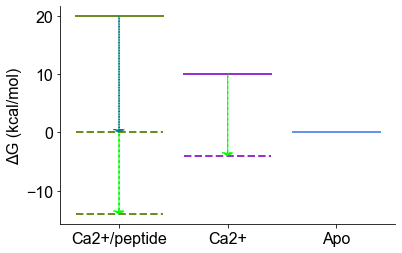

In [6]:
#call the function
print('Fig 4B: Energetic effects on S100A4 ensemble when mu peptide and mu Ca2+ increase')

plot_ensemble_levels(save_fig=False)

# Panel 4C: Plot fractional populations as a function of Ca2+ concentration

Fig 4C: Wildtype S100A4 ensemble changes as a function of mu Ca2+


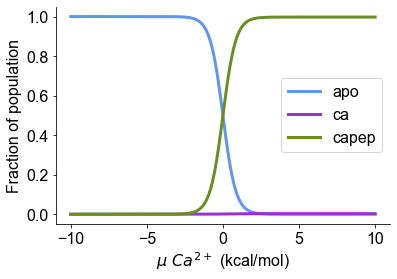

In [7]:
def pop_curves(ddG_a,ddG_c,ddG_cp, save = False):
    '''
    Plot fractional population of each state as a
    function of the negative Ca2+ chemical potential.
    ddG_a: effect of mutation of apo stability
    ddG_c: effect of mutation on ca stability
    ddG_cp: effect of mutation on cp stability
    
    '''
    
    fig, ax = plt.subplots(1,1)
    
    #calculate fractional populations
    apo, ca, capep = pops(ddG_apo=ddG_a,
                      ddG_ca=ddG_c,
                      ddG_capep=ddG_cp,
                      mu_ca=MU_CA_RANGE,
                      mu_pep=MU_PEP,
                      beta=BETA,
                      dG_apo=DG_APO,
                      dG_ca=DG_CA,
                      dG_capep=DG_CAPEP)
    
    mu_range_kcal = conv*MU_CA_RANGE
    
    #plot fractions for each structure
    ax.plot(mu_range_kcal,apo,lw=3,color='cornflowerblue',label="apo")
    ax.plot(mu_range_kcal,ca,lw=3,color='darkorchid',label="ca")
    ax.plot(mu_range_kcal,capep,lw=3,color='olivedrab',label="capep")
    

    #general plot settings
    ax.set_ylabel('Fraction of population')
    ax.set_xlabel("$\mu\ Ca^{2+}$ (kcal/mol)")
    ax.legend()
        
    fig.savefig('Fig4C-frac-wt.svg')


        
print("Fig 4C: Wildtype S100A4 ensemble changes as a function of mu Ca2+")
#call the function for WT ensemble (ddG_a, ddG_c, and ddG_cp are zero)
pop_curves(0,0,0, save = False)

# Panel 4D: Epistasis vs Ca2+ chemical potential for all mutation pairs

### Calculate maximum epistasis for each mutation pair within Ca2+ chemical potential range

In [8]:
all_mag = np.zeros(apo_ddG_mean.shape[0],dtype=np.float)
all_sign = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)
all_recip  = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)

for i in range(len(apo_ddG_mean)):
        
    mag, sign1, sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],
                                        ca_ddG_mean[i,:],
                                        capep_ddG_mean[i,:],
                                        dG_apo=DG_APO,
                                        dG_ca=DG_CA,
                                        dG_capep=DG_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=MU_CA_RANGE,
                                        additive_in_states=True,
                                        beta=BETA)
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)
    
    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    # Index of maximum epistasis over this [Ca] range
    max_index = np.argmax(np.abs(mag))
    
    # Record magnitude of epistasis
    all_mag[i] = mag[max_index]
    
    # Record whether it is reciprocal or sign at this maximum value
    all_recip[i] = reciprocal[max_index]
    all_sign[i] = sign[max_index]

C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in true_divide
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in true_divide
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in true_divide


### Plot fractional contributions of epistasis types based on cutoff threshold

Figure 4D: Fraction of each type of epistasis as a function of cutoff


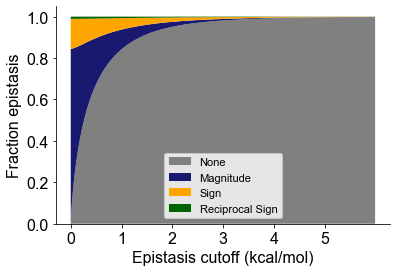

In [9]:
def plot_threshold(all_m,all_s,all_r, save_fig = False):
    '''
    Generate continuous stacked bar plot for the 
    fraction of mutation pairs composing each class 
    of epistasis as the epistatic 
    cutoff in kcal/mol is increased. 
    
    Pairs with maximum epistasis below the cutoff are
    considered to have no epistasis.
    
    Returns fx_df: dataframe with epistatic fractions
    for integer cutoff values.
    
    all_m: array with maximum epistatic magnitude 
    all_s: array with truth of sign epistasis
    all_r: array with truth of reciprocal sign epistasis
    '''
    cutoff_range=np.arange(0,6,0.01)
    int_cutoff=np.arange(0,6,0.01)

    sign_arr = np.zeros(len(cutoff_range))
    recip_arr = np.zeros(len(cutoff_range))
    mag_arr = np.zeros(len(cutoff_range))
    none_arr = np.zeros(len(cutoff_range))
    
    s_arr = np.zeros(len(int_cutoff))
    r_arr = np.zeros(len(int_cutoff))
    m_arr = np.zeros(len(int_cutoff))
    n_arr = np.zeros(len(int_cutoff))
    
    j=0


    #calculate epistasis fractions for each cutoff
    for i,cutoff in enumerate(cutoff_range):

        mask = np.abs(all_m) > cutoff

        fx_sign = np.sum(all_s[mask])/all_s.shape[0]
        sign_arr[i] = fx_sign

        fx_recip = np.sum(all_r[mask])/all_s.shape[0]
        recip_arr[i] = fx_recip

        fx_mag = np.sum(np.logical_not(np.logical_or(all_s[mask],all_r[mask])))/all_s.shape[0]
        mag_arr[i] = fx_mag

        fx_none = 1 - fx_sign - fx_recip - fx_mag
        none_arr[i] = fx_none
   
        if cutoff in cutoff_range:
            s_arr[j] = fx_sign
            r_arr[j] = fx_recip
            m_arr[j] = fx_mag
            n_arr[j] = fx_none
            j += 1
            
    fx_df = pd.DataFrame({'Cutoff kT':cutoff_range,'Fx_none':n_arr,'Fx_mag':m_arr,'Fx_sign':s_arr,'Fx_recip':r_arr})

    
    plt.stackplot(cutoff_range*conv,none_arr,mag_arr,sign_arr,recip_arr,
                  labels=['None','Magnitude','Sign','Reciprocal Sign'],
                  colors=['grey','midnightblue','orange','darkgreen'])
    
    plt.ylabel('Fraction epistasis')
    plt.xlabel('Epistasis cutoff (kcal/mol)')
    plt.xticks(np.arange(0,6,1))
    plt.legend(loc='lower center',fontsize='x-small')
    
    
    if save_fig:
        plt.savefig('Fig4D-cutoff-curves-kcal.svg')
    
    return fx_df

#Call the function
print('Figure 4D: Fraction of each type of epistasis as a function of cutoff')
fx = plot_threshold(all_m=all_mag,all_s=all_sign,all_r=all_recip, save_fig = False)

### Calculate how much epistasis in this dataset has a magnitude above 0.6 kcal/mol (1 kT) and 2 kcal/mol

In [10]:
## how many pairs are at least 0.6 kcal/mol (1 kT, thermal fluctuation)
cut = 0.6 # in kcal/mol
cutoff = cut*(1/conv) # convert 1 kcal/mol (thermal fluctuation cutoff) to kT to filter dataframe
filtered_1 = fx[fx['Cutoff kT'] >= cutoff]
print('fraction above ' + str(cut) + ' kcal/mol: ', 1-filtered_1.iloc[0,1])
print('fraction of magnitude pairs at ' + str(cut) + ' kcal/mol: ', filtered_1.iloc[0,2])
print('fraction of sign pairs at ' + str(cut) + ' kcal/mol: ', filtered_1.iloc[0,3])
print('fraction of reciprocal sign pairs at ' + str(cut) + ' kcal/mol: ', filtered_1.iloc[0,4])

###################################################################################################
## how many are above 2 kcal/mol?
high_cut = 2 # in kcal/mol
high_cutoff = high_cut * (1/conv)
filtered_5 = fx[fx['Cutoff kT'] > high_cutoff]
print('fraction above ' + str(high_cut) + ' kcal/mol: ', 1-filtered_5.iloc[0,1])

fraction above 0.6 kcal/mol:  0.27796279581271344
fraction of magnitude pairs at 0.6 kcal/mol:  0.18479424312266599
fraction of sign pairs at 0.6 kcal/mol:  0.08425972769026276
fraction of reciprocal sign pairs at 0.6 kcal/mol:  0.00890882499978459
fraction above 2 kcal/mol:  0.0484732011648662


# Figure 4E: Epistasis class switching in entire dataset and selected pairs 

### Generate dataframes containing epistasis vs ca information for the following:

1) For selected mutations at mu Ca = 3.5 kcal/mol
* M85K: apo buried charge, ca exposed charge
* F145R: apo exposed charge, ca buried charge
* F78A: apo exposed hole, ca buried hole
* L109I: apo no change, ca no change
    
2) Any pair with magnitude above 0.6 kcal/mol (1 kT)

In [11]:
all_mag_select = np.zeros(apo_ddG_mean.shape[0],dtype=np.float)
all_sign_select = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)
all_recip_select = np.zeros(apo_ddG_mean.shape[0],dtype=np.bool)

for i in range(len(apo_ddG_mean)):
    
    
    # first we calculate epistasis at a single mu Ca2+ = 3.5 kT
    mag, sign1, sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],
                                        ca_ddG_mean[i,:],
                                        capep_ddG_mean[i,:],
                                        dG_apo=DG_APO,
                                        dG_ca=DG_CA,
                                        dG_capep=DG_CAPEP,
                                        mu_pep=MU_PEP,
                                        mu_ca_range=3.5,
                                        additive_in_states=True,
                                        beta=BETA)
    
    
    # If sign on both, reciprocal
    reciprocal = np.logical_and(sign1,sign2)
    
    # Sign (as a class) will be sign on one mut but *not* reciprocal
    sign = np.logical_and(np.logical_or(sign1,sign2),
                          np.logical_not(reciprocal))
    
    # Record magnitude of epistasis
    all_mag_select[i] = mag
    
    # Record whether it is reciprocal or sign at this maximum value
    all_recip_select[i] = reciprocal
    all_sign_select[i] = sign

C:\Users\wonde\PyMOL\envs\epistasis_project\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
# generate dataframe of epistasis magnitude for selected mutants 
# at 3.5 kcal/mol mu Ca

df = pd.DataFrame({'m1':muts[:,1],'m2':muts[:,0],
                   'apo_m1':apo_ddG_mean[:,0],'apo_m2':apo_ddG_mean[:,1],
                   'ca_m1':ca_ddG_mean[:,0],'ca_m2':ca_ddG_mean[:,1],
                   'capep_m1':capep_ddG_mean[:,0],'capep_m2':capep_ddG_mean[:,1],
                   'all_mag_sel':all_mag_select,'all_sign_sel':all_sign_select,'all_recip_sel':all_recip_select})

select_muts = ['M85K','F145R','F78A','L109I']

check_m1 = df.m1.isin(select_muts)
check_m2 = df.m2.isin(select_muts)

select_df = df[check_m1 & check_m2]
print(select_df.head())

## grab example mutation pairs: F145R/M85K, F145R/L109I, F145R/F78A
#Sign: F145R + M85K (opposite directions equal magnitude)
s_idx = 3652201

#Magnitude: F145R + F78A (diff mag but same direction)
m_idx = 4876241

#None: F145R + L109I
n_idx = 3983508

index_list = [s_idx, m_idx, n_idx]

ex1_df = select_df.loc[index_list]
ex1_df = ex1_df.reset_index()
ex1_df.loc[:,"index"] = 0
ex1_df

ex_df = ex1_df[['index','m2','m1','apo_m2','apo_m1',
                'ca_m2','ca_m1','capep_m2','capep_m1',
                'all_mag_sel','all_sign_sel','all_recip_sel']]

ex_arr = ex_df.values

name_arr = ex_arr[:,[1,2]]
apo_ddg_arr = ex_arr[:,[3,4,0]]
ca_ddg_arr = ex_arr[:,[5,6,0]]
capep_ddg_arr = ex_arr[:,[7,8,0]]
type_arr = np.array(['Sign','Magnitude','None'])

#####################################################################

## Grab pairs of mutations with magnitude of epistasis > 0.6 kcal/mol
## at 3.5 kcal/mol mu Ca

cutoffs = 0.6 # in kcal/mol
df2 = df.copy(deep=True)
df2['abs_mag'] = np.abs(df2.all_mag_sel)

df_strong_epi = df2[df2.abs_mag >= cutoffs*(1/conv)]


vals = df_strong_epi.values

apo_ddg = vals[:,[3,4,0]]
ca_ddg = vals[:,[5,6,0]]
capep_ddg = vals[:,[7,8,0]]
epi_type = np.array(['Sign','Magnitude','None'])

df_strong_epi.head()

            m1     m2  apo_m1  apo_m2  ca_m1   ca_m2  capep_m1  capep_m2  \
3650640   M85K  L109I   7.809   0.021  2.213   0.059     5.786     0.274   
3651212   M85K   F78A   7.809   4.761  2.213  11.287     5.786    13.262   
3652201   M85K  F145R   7.809  -1.032  2.213   7.495     5.786     4.487   
3982518  L109I   F78A   0.021   4.761  0.059  11.287     0.274    13.262   
3983508  L109I  F145R   0.021  -1.032  0.059   7.495     0.274     4.487   

         all_mag_sel  all_sign_sel  all_recip_sel  
3650640    -0.003163         False          False  
3651212    -2.467628         False          False  
3652201    -3.773072         False           True  
3982518     0.027805         False          False  
3983508     0.032289         False          False  


,m1,m2,apo_m1,apo_m2,ca_m1,ca_m2,capep_m1,capep_m2,all_mag_sel,all_sign_sel,all_recip_sel,abs_mag
3364,N87D,E23P,-1.19,3.737,1.736,13.173,1.839,15.832,2.304414,False,False,2.304414
3365,N87D,E23F,-1.19,-3.281,1.736,-0.206,1.839,-1.378,1.113704,True,False,1.113704
3366,N87D,L137A,-1.19,6.374,1.736,8.995,1.839,8.532,0.930189,False,False,0.930189
3367,N87D,L5R,-1.19,7.942,1.736,14.004,1.839,14.457,2.007733,False,False,2.007733
3369,N87D,K28F,-1.19,-0.452,1.736,3.708,1.839,1.919,1.517853,True,False,1.517853


### Switching statistics: how many mutation pairs in the dataset switch epistasis type? how many don't switch?

In [25]:
# Sweep through MU_CA_RANGE (-5,10.5,0.1) and calculate epistasis using epistasis_vs_ca function

d = []
no_switch = []

mu_range = np.arange(-5,10.5,.1)


mag_only = 0
sign_only = 0
reciprocal_only = 0
weird = 0
for i in df_strong_epi.index.values:

        
        m1 = df_strong_epi.m1[i]
        m2 = df_strong_epi.m2[i]
        

        mag,sign1,sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],ca_ddG_mean[i,:],capep_ddG_mean[i,:],
                                          dG_apo=DG_APO,dG_ca=DG_CA,dG_capep=DG_CAPEP,
                                          mu_pep=MU_PEP,mu_ca_range=mu_range,
                                          additive_in_states=True,beta=BETA) 

        
       
        epi_arr = np.copy(mag)
        reciprocal = np.logical_and(sign1,sign2)
        for k in range(len(mag)):
            
            if np.abs(mag[k]) < cutoffs*(1/conv):
                epi_arr[k] = np.nan
                # no epistasis 
            
            elif sign1[k] == False and sign2[k] == False:
                epi_arr[k] = 1
                # 1 = magnitude

            elif np.logical_and(np.logical_or(sign1[k],sign2[k]),np.logical_not(np.logical_and(sign1[k],sign2[k]))):
                # Sign (as a class) will be sign on one mut but *not* reciprocal
                epi_arr[k] = 2
                # 2 = sign

            elif np.logical_and(sign1[k],sign2[k]):
                epi_arr[k] = 3
                # If sign on both, reciprocal
                # 3 = reciprocal sign



        if len(np.unique(epi_arr[~np.isnan(epi_arr)])) > 1:
            df = pd.DataFrame({'mut1': m1, 'mut2': m2, 'magnitude': mag, 'type': epi_arr}, index = mu_range)


            d.append(df)
            
            
            
        elif len(np.unique(epi_arr[~np.isnan(epi_arr)])) == 1:
            df = pd.DataFrame({'mut1': m1, 'mut2': m2, 'magnitude': mag, 'type': epi_arr}, index = mu_range)
            no_switch.append(df)
            
    
            if 1 in list(np.unique(epi_arr[~np.isnan(epi_arr)])):
                mag_only +=1
                
            elif 2 in list(np.unique(epi_arr[~np.isnan(epi_arr)])):
                sign_only += 1
                
            elif 3 in list(np.unique(epi_arr[~np.isnan(epi_arr)])):
                reciprocal_only += 1
            
            else: 
                weird += 1

In [27]:
recip_mag = 0
recip_sign = 0
recip_3 = 0
all_recip = 0

sign_mag = 0
sign_recip = 0
sign_3 = 0
all_sign = 0

mag_sign = 0
mag_recip = 0
mag_3 = 0
all_mag = 0


for dfs in d:

    if 3.0 in list(dfs.type):
        data = dfs.dropna()
        all_recip += 1
        if (len(np.unique(data.type))) == 2 and 1.0 in list(data.type):
            recip_mag += 1
            all_mag += 1
            
            
 
            
        elif (len(np.unique(data.type))) == 2 and 2.0 in list(data.type):
            recip_sign += 1
            all_sign += 1
            
            
        elif (len(np.unique(data.type))) == 3:
            recip_3 += 1
            all_sign += 1
            all_mag += 1
            
            
    elif 2.0 in list(dfs.type):
        data = dfs.dropna()
        all_sign += 1
        if (len(np.unique(data.type))) == 2 and 1.0 in list(data.type):
            all_mag += 1
            sign_mag += 1
            
            

    else:
        pass
                

In [28]:
print('magnitude only pairs of those that dont switch: ', (mag_only)/(len(no_switch)))
print('sign only pairs of those that dont switch: ', (sign_only)/(len(no_switch)))
print('reciprocal sign only pairs of those that dont switch: ', (reciprocal_only)/len(no_switch))


print('magnitude only pairs of all pairs above 0.6 kcal/mol: ', (mag_only)/(len(df_strong_epi)))
print('sign only pairs of all pairs above 0.6 kcal/mol: ', (sign_only)/(len(df_strong_epi)))
print('reciprocal only pairs of all pairs above 0.6 kcal/mol: ', (reciprocal_only)/(len(df_strong_epi)))
print('pairs that switch above 0.6 kcal/mol: ', (len(d))/(len(df_strong_epi)))

magnitude only pairs of those that dont switch:  0.9751499022028409
sign only pairs of those that dont switch:  0.0248404784044634
reciprocal sign only pairs of those that dont switch:  9.61939269567448e-06
magnitude only pairs of all pairs above 0.6 kcal/mol:  0.31366773209731
sign only pairs of all pairs above 0.6 kcal/mol:  0.007990214127837238
reciprocal only pairs of all pairs above 0.6 kcal/mol:  3.094183862593483e-06
pairs that switch above 0.6 kcal/mol:  0.6783389595909901


### Out of the pairs that have high magnitude, what is the breakdown in what types switch between each other?

In [29]:
print('fraction of all switchers that transition between sign, reciprocal sign, and magnitude epistasis: ', 
      recip_3/len(d))


print('fraction of all switchers reciprocal <-> magnitude: ', recip_mag/len(d))
print('fraction of all switchers reciprocal <-> sign: ', recip_sign/len(d))
print('fraction of all switchers sign <-> magnitude: ', sign_mag/len(d))


print('fraction of all switchers that contain reciprocal sign: ', all_recip/len(d))
print('fraction of all switchers that contain sign: ', all_sign/len(d))
print('fraction of all switchers that contain magnitude: ', all_mag/len(d))

fraction of all switchers that transition between sign, reciprocal sign, and magnitude epistasis:  0.22104453307100141
fraction of all switchers reciprocal <-> magnitude:  0.0022122851004499075
fraction of all switchers reciprocal <-> sign:  0.006880130638856241
fraction of all switchers sign <-> magnitude:  0.7698630511896924
fraction of all switchers that contain reciprocal sign:  0.23013694881030758
fraction of all switchers that contain sign:  0.9977877148995501
fraction of all switchers that contain magnitude:  0.9931198693611437


### Plot ca-dependent epistatic magnitude and type for select pairs (F145R/L109I, F145R/M85K, and F145R/F78A)

In [30]:
# isolate data for M85K/F145R, L109I/F145R, F78A/F145R
df85 = df_strong_epi[(df_strong_epi.m1 == 'M85K') & (df_strong_epi.m2 == 'F145R')]
df78 = df_strong_epi[(df_strong_epi.m1 == 'F78A') & (df_strong_epi.m2 == 'F145R')]
df109 = df2[(df2.m1 == 'L109I') & (df2.m2 == 'F145R')]
   
d_list = [df85, df78, df109]
concat = pd.concat(d_list)
    
vals_muts = concat.values    
apo_ddg_muts = vals_muts[:,[3,4,0]]
ca_ddg_muts = vals_muts[:,[5,6,0]]
capep_ddg_muts = vals_muts[:,[7,8,0]]
epi_type = np.array(['Sign','Magnitude','None'])


#####################################################################################
## Calculate epistasis magnitude and type as a function
## of mu_ca (in kT)
mutations = []
mu_range = np.arange(-5,10.5,0.00001) # in kT
for i in concat.index.values:
        # get mutation IDs
        m1 = concat.m1[i]
        m2 = concat.m2[i]
        
        # calculate epistasis as fxn of mu Ca
        mag,sign1,sign2 = epistasis_vs_ca(apo_ddG_mean[i,:],ca_ddG_mean[i,:],capep_ddG_mean[i,:],
                                          dG_apo=DG_APO,dG_ca=DG_CA,dG_capep=DG_CAPEP,
                                          mu_pep=MU_PEP,mu_ca_range=mu_range,
                                          additive_in_states=True,beta=BETA) 

        
       # loop through to calculate epistasis type as a fxn of mu Ca
        epi_arr = np.copy(mag)
        reciprocal = np.logical_and(sign1,sign2)
        for k in range(len(mag)):
            
            if np.abs(mag[k]) < cutoffs*(1/conv):
                epi_arr[k] = 0
                # no epistasis 
            
            elif sign1[k] == False and sign2[k] == False:
                epi_arr[k] = 1
                # 1 = magnitude

            elif np.logical_and(np.logical_or(sign1[k],sign2[k]),np.logical_not(np.logical_and(sign1[k],sign2[k]))):
                # Sign (as a class) will be sign on one mut but *not* reciprocal
                epi_arr[k] = 2
                # 2 = sign

            elif np.logical_and(sign1[k],sign2[k]):
                epi_arr[k] = 3
                # If sign on both, reciprocal
                # 3 = reciprocal sign



        # generate a dataframe for each mutant
        df = pd.DataFrame({'mut1': m1, 'mut2': m2, 'magnitude': (conv)*mag, 'type': epi_arr}, index = (conv)*mu_range)
        mutations.append(df)
            
            
# isolate each mutation dataframe from list           
m85_types = mutations[0].dropna()
f78_types = mutations[1].dropna()     
l109_types = mutations[2].dropna()    


In [31]:
#####################################################################################
# prepare for plotting
color_dict ={2.0: 'orange',1.0: 'midnightblue',0.0: 'grey', 3.0: 'darkgreen'}

f78_mag_1 = f78_types[(f78_types.type == 1.0) & (f78_types.index.values < 4.5)]
f78_mag_2 = f78_types[(f78_types.type == 1.0) & (f78_types.index.values > 4.5)]

m85_mag_1 = m85_types[(m85_types.type == 1.0) & (m85_types.index.values < 3)]
m85_mag_2 = m85_types[(m85_types.type == 1.0) & (m85_types.index.values > 3)]


f78_sign = f78_types[f78_types.type ==2.0]
m85_sign = m85_types[(m85_types.type == 2.0) & (m85_types.index.values < 3)]
m85_sign_2 = m85_types[(m85_types.type == 2.0) & (m85_types.index.values > 3)]


f78_recip = f78_types[f78_types.type == 3.0]
m85_recip = m85_types[m85_types.type == 3.0]


f78_no = f78_types[(f78_types.type == 0.0) & (f78_types.index.values < 4.5)]
f78_no_2 = f78_types[(f78_types.type == 0.0) & (f78_types.index.values > 4.5)]
m85_no = m85_types[(m85_types.type == 0.0) & (m85_types.index.values < 3)]
m85_no_2 = m85_types[(m85_types.type == 0.0) & (m85_types.index.values > 3)]

l109_no = l109_types[(l109_types.type == 0.0)]

Figure 4E: Epistasis magnitude as a function of mu Ca2+ for the M85K/F145R, L109I/F145R, and F78A/F145R mutation pairs 


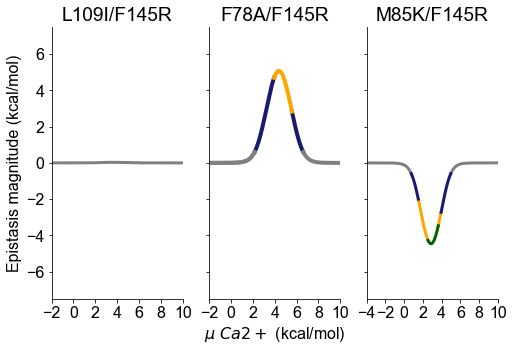

In [32]:
# plot
save = False
fig, (ax1,ax2,ax3) = plt.subplots(1,3, sharex=True, sharey=True, figsize = (8,5))

ax2.plot(f78_mag_1.index.values, f78_mag_1.magnitude, color = color_dict[1.0],
         label = 'F78A/F145R', linewidth = 4)
ax2.plot(f78_mag_2.index.values, f78_mag_2.magnitude, color = color_dict[1.0],
         linewidth = 4)
ax2.plot(f78_no.index.values,    f78_no.magnitude,    color = color_dict[0.0],
         linewidth = 4)
ax2.plot(f78_no_2.index.values,  f78_no_2.magnitude,  color = color_dict[0.0],
         linewidth = 4)
ax2.plot(f78_no.index.values,    f78_no.magnitude,    color = color_dict[0.0],
         linewidth = 4)
ax2.plot(f78_sign.index.values,  f78_sign.magnitude,  color = color_dict[2.0],
         linewidth = 4)
ax2.plot(f78_recip.index.values, f78_recip.magnitude, color = color_dict[3.0],
         linewidth = 4)


ax3.plot(m85_sign.index.values,   m85_sign.magnitude,   color = color_dict[2.0],
         label = 'M85K/F145R', linewidth = 3)
ax3.plot(m85_sign_2.index.values, m85_sign_2.magnitude, color = color_dict[2.0],
         linewidth = 3)
ax3.plot(m85_recip.index.values,  m85_recip.magnitude,  color = color_dict[3.0],
         linewidth = 3)
ax3.plot(m85_no_2.index.values,   m85_no_2.magnitude,   color = color_dict[0.0],
         linewidth = 3)
ax3.plot(m85_no.index.values,     m85_no.magnitude,     color = color_dict[0.0],
         linewidth = 3)
ax3.plot(m85_mag_1.index.values,  m85_mag_1.magnitude,  color = color_dict[1.0],
         linewidth = 3)
ax3.plot(m85_mag_2.index.values,  m85_mag_2.magnitude,  color = color_dict[1.0],
         linewidth = 3)



ax1.plot(l109_no.index.values, l109_no.magnitude, color = color_dict[0.0],
         label = 'L109I/F145R', linewidth = 3)



ax2.set_title('F78A/F145R')
ax3.set_title('M85K/F145R')
ax1.set_title('L109I/F145R')
ax1.set_ylabel("Epistasis magnitude (kcal/mol)")
ax2.set_xlabel("$\mu\ Ca{2+}$ (kcal/mol)")
ax1.set_xlim(-2,10)
ax2.set_xlim(-2,10)
ax3.set_xlim(-2,10)
plt.ylim(-7.5,7.5)
plt.xticks(np.arange(-4,11,2))
save = False
if save:
    plt.savefig('fig-4e-stacked.pdf')
print('Figure 4E: Epistasis magnitude as a function of mu Ca2+ for the M85K/F145R, L109I/F145R, and F78A/F145R mutation pairs ')
plt.show()

# Panels 4G-J: Energy diagrams for selected mutation pairs at mu ca = 3.5 kcal/mol

### Plotting functions

In [20]:
def _plot_states_ca(dG_apo=0,dG_ca=0,                        
                    ddG_apo=None,ddG_ca=None,         
                    observable=0,x_location=0,
                    arrow_colors=None):                              
    """
    Draw conformation energies and effects of mutations for a given genotype.
    
    dG_apo: stability of apo before mutation
    dG_ca: stability of ca before mutation
    ddG_apo: effect of mutations to apo structure.  
           If None, no mutations.
           If float, single mutation (one arrow).
           If list of floats, multiple mutations (each with own arrow)
    ddG_ca: effect of mutations to ca.  (Same syntax as ddG_apo).
    observable: observable <dGapo,ca>
    x_location: where to draw states on total plot.
    arrow_colors: color to draw each arrow.
                  If None, all arrows black.
                  Otherwise, must be a list of colors, in order.  Arrows are
                  plotted in order ddG_apo, then ddG_ca.   
    """
    
    # x-placement for edges of genotypes
    x0 = 0
    x1 = 2
    x2 = 2.5
    x3 = 4.5

    # If ddG_ca specified, add dashed line for dG_ca
    if ddG_ca is None:
        ddG_ca = 0
    else:        
        plt.plot([x0+x_location,x1+x_location],[conv*dG_ca,
                                                conv*dG_ca],"--",
                 lw=2,color="darkorchid",zorder=10)
        
    # If ddG_apo is specified, add dashed line for dG_apo
    if ddG_apo is None:
        ddG_apo = 0
        
    else:        

        plt.plot([x2+x_location,x3+x_location],[conv*dG_apo,
                                                conv*dG_apo],"--",
                 lw=2,color="cornflowerblue",zorder=10)
    

    # If ddG_ca is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    try:
        len(ddG_ca)
        total_ddG_ca = sum(ddG_ca)
    except TypeError:
        total_ddG_ca = ddG_ca
        ddG_ca = [ddG_ca,]
        
    # If ddG_apo is a list, grab total shift.  If it is not a list, treat as total 
    # shift and turn into a list.
    try:
        len(ddG_apo)
        total_ddG_apo = sum(ddG_apo)
    except TypeError:
        total_ddG_apo = ddG_apo
        ddG_apo = [ddG_apo,]
    
    # Plot energy levels

    plt.plot([x0+x_location,x1+x_location],[conv*dG_ca  + conv*total_ddG_ca,
                                            conv*dG_ca  + conv*total_ddG_ca],
             lw=2,color="darkorchid",zorder=10)
    plt.plot([x2+x_location,x3+x_location],[conv*dG_apo + conv*total_ddG_apo,
                                            conv*dG_apo + conv*total_ddG_apo],
             lw=2,color="cornflowerblue",zorder=10)
    
    # Plot observable
    plt.plot([x0+x_location,x3+x_location],[conv*observable,
                                            conv*observable],lw=4,color="black",zorder=0)
    
    # Count through arrow colors
    color_counter = 0
        
    current = conv*dG_ca
    for counter, ca_arrow in enumerate(ddG_ca):
        
        # If this ddG is 0, do not draw an arrow
        if ca_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x0 + (x1 - x0)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = ca_arrow/np.abs(ca_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,conv*current,0,conv*ca_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + ca_arrow
        color_counter += 1
        
    current = conv*dG_apo
    for counter, apo_arrow in enumerate(ddG_apo):
        
        # If this ddG is 0, do not draw an arrow
        if apo_arrow == 0:
            continue
        
        # Figure out where to draw arrow (x-position)
        x = x2 + (x3 - x2)/2 + x_location
    
        # Figure out if arrow goes up or down
        sign = apo_arrow/np.abs(apo_arrow)
        
        # Figure out arrow color
        if arrow_colors is not None:
            c = arrow_colors[color_counter]
        else:
            c = "black"
        
        # Draw arrow
        plt.arrow(x,conv*current,0,conv*apo_arrow -sign*0.25,color=c,width=0.2,head_length=0.50,zorder=20)
        
        # Update counters
        current = current + apo_arrow
        color_counter += 1
        
    plt.ylabel('ΔG (kcal/mol)')

    
def plot_state_cycle_ca(index,apo_ddG,ca_ddG,capep_ddG,
                        dG_apo,dG_ca,dG_capep,
                        mu_pep,mu_ca,
                        additive_in_states=True,beta=BETA,
                        ylim=(-12,18)):
    """
    Calculate epistasis for the system as a function of calcium concentration.
    
    apo_ddG: effect of mutation 1, mutation 2, and mutation 12 on apo stability
    ca_ddG: effect of mutation 1, mutation 2, and mutation 12 on ca stability
    capep_ddG: effect of mutation 1, mutation 2, and mutation 12 on capep stability
    apo_dG: free energy of apo state
    ca_dG: free energy of ca state (no ca)
    capep_dG: free energy of ca/pep state (no ca, no pep)
    mu_pep: chemical potential of peptide
    mu_ca_range: chemical potential range of calcium
    additive_in_states: assume that ddG terms sum within each state. If False,
                        the ddG effect of the double mutant would need to 
                        have been calculated in rosetta.
    beta: 1/RT
    """
    
    #apo_ddG = apo_ddG*conv 
    #ca_ddG = ca_ddG*conv
    #capep_ddG = capep_ddG*conv
    #dG_apo = dG_apo*conv
    #dG_ca = dG_ca*conv
    #dG_capep = dG_capep*conv
    #mu_pep = mu_pep*conv
    #mu_ca = mu_ca*conv
    # If we are assuming mutations are additive within a state, 
    # throw out the (possibly) calculated ddG12 value. 
    if additive_in_states:
        apo_ddG[2] = apo_ddG[0] + apo_ddG[1]
        ca_ddG[2] = ca_ddG[0] + ca_ddG[1]
        capep_ddG[2] = capep_ddG[0] + capep_ddG[1]
    
    # free energy of capep for each genotype
    ab =  dg_obs(ddG_apo=0,
                 ddG_ca=0,
                 ddG_capep=0,                          
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    Ab =  dg_obs(ddG_apo=apo_ddG[0],
                 ddG_ca=ca_ddG[0],
                 ddG_capep=capep_ddG[0],  
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    aB =  dg_obs(ddG_apo=apo_ddG[1],
                 ddG_ca=ca_ddG[1],
                 ddG_capep=capep_ddG[1], 
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)
    
    AB = dg_obs(ddG_apo=apo_ddG[2],
                 ddG_ca=ca_ddG[2],
                 ddG_capep=capep_ddG[2],  
                 mu_ca=mu_ca,
                 mu_pep=mu_pep,
                 dG_apo=dG_apo,
                 dG_ca=dG_ca,
                 dG_capep=dG_capep,
                 beta=beta)  
    
    
    dG_j = -(1/beta)*np.log(np.exp(-beta*(dG_apo)))
    dG_k = -(1/beta)*np.log(np.exp(-beta*(dG_ca - 4*mu_ca)))
    ddG_Aj, ddG_Bj = apo_ddG[0:2]
    ddG_Ak, ddG_Bk = ca_ddG[0:2]

    # Plot states for each genotype, offseting by x_location for each one
    _plot_states_ca(dG_j,dG_k,observable=ab,x_location=0)
    _plot_states_ca(dG_j,dG_k,[ddG_Aj],[ddG_Ak],observable=Ab,x_location=6,arrow_colors=["orange","orange"])
    _plot_states_ca(dG_j,dG_k,[ddG_Bj],[ddG_Bk],observable=aB,x_location=12,arrow_colors=["green","green"])
    _plot_states_ca(dG_j,dG_k,[ddG_Bj,ddG_Aj],[ddG_Bk,ddG_Ak],observable=AB,x_location=18,
                    arrow_colors=["green","orange","green","orange"])
    
    # print relative populations
    print('ab, j: ' , np.exp(-dG_j)/(np.exp(-dG_j) + np.exp(-dG_k)))
    print('ab, k: ' , np.exp(-dG_k)/(np.exp(-dG_j) + np.exp(-dG_k)))
    
    print('Ab, j: ' , np.exp(-(dG_j + ddG_Aj))/(np.exp(-(dG_j + ddG_Aj)) + np.exp(-(dG_k + ddG_Ak))))
    print('Ab, k: ' , np.exp(-(dG_k + ddG_Ak))/(np.exp(-(dG_j + ddG_Aj)) + np.exp(-(dG_k + ddG_Ak))))
    
    print('aB, j: ' , np.exp(-(dG_j + ddG_Bj))/(np.exp(-(dG_j + ddG_Bj)) + np.exp(-(dG_k + ddG_Bk))))
    print('aB, k: ' , np.exp(-(dG_k + ddG_Bk))/(np.exp(-(dG_j + ddG_Bj)) + np.exp(-(dG_k + ddG_Bk))))

    print('AB, j: ' , np.exp(-(dG_j + ddG_Aj + ddG_Bj))/(np.exp(-(dG_j + ddG_Aj + ddG_Bj)) + np.exp(-(dG_k + ddG_Ak +  ddG_Bk))))
    print('AB, k: ' , np.exp(-(dG_k + ddG_Ak + ddG_Bk))/(np.exp(-(dG_j + ddG_Aj + ddG_Bj)) + np.exp(-(dG_k + ddG_Ak +  ddG_Bk))))

    
    
    
    # Print epistasis
    print("Ab-ab:",Ab-ab)
    print("AB-aB:",AB-aB,'\n')
    print("aB-ab:",aB-ab)
    print("AB-Ab",AB-Ab)
    print("Epistasis:",(AB-aB)-(Ab-ab))
    
    plt.ylim(ylim)
    plt.xticks([2,8,14,20],['ab','Ab','aB','AB'])

    plt.yticks(np.arange(-12,18,4))
    return None

def ex_plot(index,figure=None,MU_CA_E=3.5):
    '''
    Plot energy diagrams for mutations at indicated index in 
    the ex_df dataframe (0:sign, 1:magnitude, 2:no epistasis)

    Ca2+ chemical potential is set at 3.5 kT.

    index: position in ex_df dataframe    
    '''
    
    m1,m2 = name_arr[index,:]
    print('A: {}, B: {}'.format(m1,m2))   
    
    #create energy diagrams at mu ca = 3.5 kT
    plot_state_cycle_ca(index,apo_ddg_arr[index,:],ca_ddg_arr[index,:],capep_ddg_arr[index,:],
                        dG_apo=DG_APO,dG_ca=DG_CA,dG_capep=DG_CAPEP,
                        mu_pep=MU_PEP,mu_ca=MU_CA_E)
    
    if figure != None:
        plt.savefig(figure + '.pdf')
    
    
    return None

###  Figure 4G-H: No epistasis pair F145R + L109I

A: F145R, B: L109I
ab, j:  0.01798620996209156
ab, k:  0.9820137900379085
Ab, j:  0.9893026049828827
Ab, k:  0.010697395017117337
aB, j:  0.01866983211930766
aB, k:  0.9813301678806923
AB, j:  0.9896973699278044
AB, k:  0.01030263007219559
Ab-ab: 1.4797025218369342
AB-aB: 1.5119910856976215 

aB-ab: 0.21829383882197106
AB-Ab 0.2505824026826584
Epistasis: 0.03228856386068735


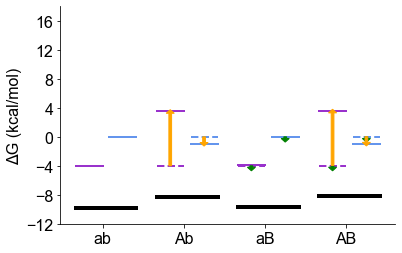

In [21]:
ex_plot(2, 'fig-4g-4h')

### Figure 4I: Magnitude epistasis pair F145R + F78A

A: F145R, B: F78A
ab, j:  0.01798620996209156
ab, k:  0.9820137900379085
Ab, j:  0.9893026049828827
Ab, k:  0.010697395017117337
aB, j:  0.9259445352764824
aB, k:  0.07405546472351762
AB, j:  0.9999841606916837
AB, k:  1.5839308316266962e-05
Ab-ab: 1.4797025218369342
AB-aB: 5.179157710694986 

aB-ab: 4.691649264405984
AB-Ab 8.391104453264036
Epistasis: 3.6994551888580522


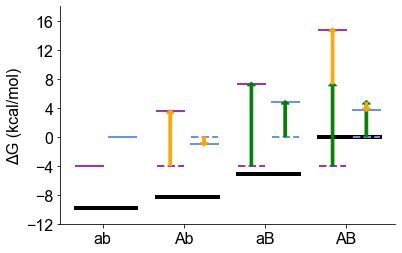

In [22]:
ex_plot(1, 'fig-4i')

### Figure 4J: Reciprocal sign epistasis pair F145R + M85K

A: F145R, B: M85K
ab, j:  0.01798620996209156
ab, k:  0.9820137900379085
Ab, j:  0.9893026049828827
Ab, k:  0.010697395017117337
aB, j:  6.799557027790273e-05
aB, k:  0.9999320044297222
AB, j:  0.2555933030323866
AB, k:  0.7444066969676133
Ab-ab: 1.4797025218369342
AB-aB: -2.2933692595234865 

aB-ab: 3.4271444372509725
AB-Ab -0.34592734410944814
Epistasis: -3.7730717813604207


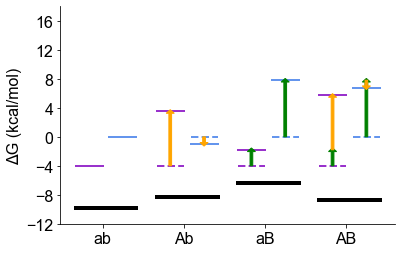

In [23]:
ex_plot(0, 'fig-4j')

# Panels 4K-L: Energy diagrams for F145R + M85K pair at mu ca = 1.5 kcal/mol

A: F145R, B: M85K
ab, j:  0.9835259887690313
ab, k:  0.016474011230968727
Ab, j:  0.9999966827131311
Ab, k:  3.317286868909211e-06
aB, j:  0.181437278902166
aB, k:  0.818562721097834
AB, j:  0.9991072938627179
AB, k:  0.0008927061372820453
Ab-ab: 5.375816262296164
AB-aB: 3.4576965103823585 

aB-ab: -0.07948004954450738
AB-Ab -1.9975998014583127
Epistasis: -1.9181197519138053


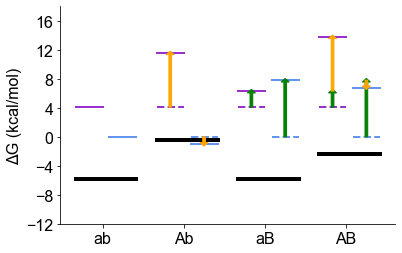

In [24]:
mus = 1.47766

ex_plot(0, 'fig-4k-4l', MU_CA_E = mus)

# Not shown in Figure 4

### Effect of peptide on the ensemble

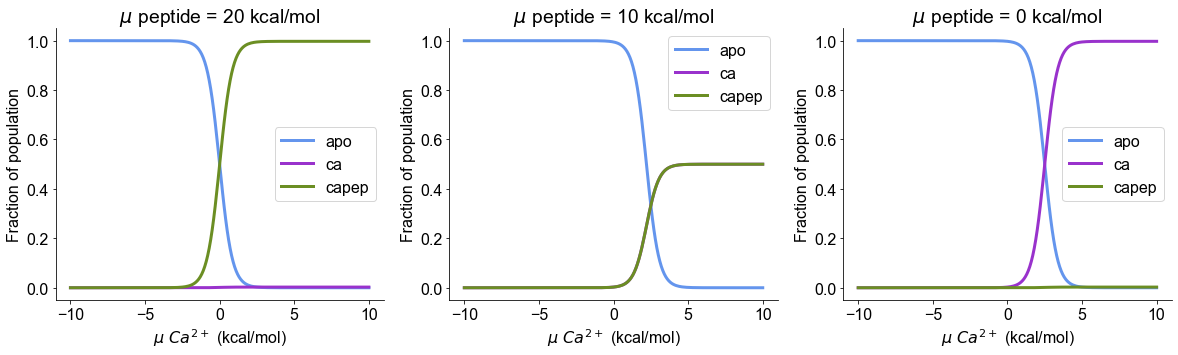

In [18]:
def pep_curves(ddG_a,ddG_c,ddG_cp):
    '''
    Plot fractional population of each state as a
    function of the negative Ca2+ chemical potential.
    ddG_a: effect of mutation of apo stability
    ddG_c: effect of mutation on ca stability
    ddG_cp: effect of mutation on cp stability
    
    '''
    
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    
    peps = [20,10,0]
    
    for i in range(3):
    
        #calculate fractional populations
        apo, ca, capep = pops(ddG_apo=ddG_a,
                          ddG_ca=ddG_c,
                          ddG_capep=ddG_cp,
                          mu_ca=MU_CA_RANGE,
                          mu_pep=peps[i],
                          beta=BETA,
                          dG_apo=DG_APO,
                          dG_ca=DG_CA,
                          dG_capep=DG_CAPEP)
        
        #plot fractions for each structure
        ax[i].plot(MU_CA_RANGE*conv,apo,lw=3,color='cornflowerblue',label="apo")
        ax[i].plot(MU_CA_RANGE*conv,ca,lw=3,color='darkorchid',label="ca")
        ax[i].plot(MU_CA_RANGE*conv,capep,lw=3,color='olivedrab',label="capep")

        #general plot settings
        ax[i].set_ylabel('Fraction of population')
        ax[i].set_xlabel("$\mu\ Ca^{2+}$ (kcal/mol)")
        ax[i].set_title("$\mu\ $peptide = {} kcal/mol".format(str(peps[i])))
        ax[i].legend()
        #fig.savefig('Fig4-pepmanip2.pdf')
        
#call the function
pep_curves(0,0,0)

### Histogram of maximum epistatic magnitude (and type) for every mutation pair

Distribution of the magnitude of each type of epistasis in our entire dataset


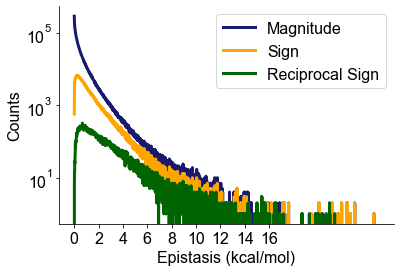

In [19]:
def plot_maxepistasis(save_fig=False):
    '''
    Plot histogram of each pair's maximum epistasis
    within Ca chemical potential range.
    
    Uses all_mag, all_sign, and all_recip to retrieve
    the value and type of epistasis at maximum Ca2+ position.
    
    Counts (y-axis) on log scale
    '''
    
    
    fig,ax = plt.subplots(1,1)
    bins=np.arange(0,25*conv,0.01*conv)

    counts, _ = np.histogram(conv*abs(all_mag[np.logical_not(np.logical_and(all_sign,all_recip))]),bins)
    out_bins = (bins - (bins[1] - bins[0])/2)[1:]
    ax.plot(out_bins,counts,"-",color="midnightblue",label="Magnitude",linewidth=3)

    counts, _ = np.histogram(conv*abs(all_mag[all_sign]),bins)
    ax.plot(out_bins,counts,"-",color="orange",label="Sign",linewidth=3)

    counts, _ = np.histogram(conv*abs(all_mag[all_recip]),bins)
    ax.plot(out_bins,counts,"-",color="darkgreen",label="Reciprocal Sign",linewidth=3)

    ax.set_xlabel("Epistasis (kcal/mol)")
    ax.set_ylabel("Counts")
    ax.set_yscale("log")
    ax.legend(loc="upper right")
    ax.set_xticks(range(0,17,2))
    if save_fig:
        fig.savefig('final-figures/Fig4-epistasis-counts.svg')
    
# call the function
print('Distribution of the magnitude of each type of epistasis in our entire dataset')
plot_maxepistasis()